In [195]:
!pip install datefinder
!pip install spacy
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 66.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [196]:
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.model_selection import train_test_split
import random
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
import warnings
import datefinder
import spacy
from spacy.tokens import DocBin
import random
#import json
#from pathlib import Path
from spacy.training import Example
from spacy.scorer import Scorer
import os
from spacy.lang.ru import Russian
warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [197]:
jayguard_dataset = load_dataset('just-ai/jayguard-ner-benchmark')
print(jayguard_dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 850
    })
})


Все метки датасета:

In [198]:
all_tags = np.array([])
for i in range(len(jayguard_dataset['train'])):
    all_tags = np.concatenate((all_tags, jayguard_dataset['train']['ner_tags'][i]))

ner_tags = np.unique(all_tags)

num_tags = len(ner_tags)
tag2id = {label: i for i, label in enumerate(ner_tags)}

print(f"Количество классов: {num_tags}")
print(f"Метки NER: {ner_tags}")

Количество классов: 12
Метки NER: ['B-FICT' 'B-GPE' 'B-PER' 'B-PERSON' 'B-PER_PUBLIC' 'B-PET' 'B-PUBLIC_PER'
 'B-PUBLIC_PERSON' 'B-PUBLIC_PLACES' 'B-STREET_ADDRESS' 'B-THEO' 'O']


In [199]:
words = jayguard_dataset['train'][0]['tokens']
tags = jayguard_dataset['train'][0]['ner_tags']
decoded_tags = [tag_id for tag_id in tags]

print("Метки для первой строки")
for word, tag in zip(words, decoded_tags):
    print(f"{word:<20} {tag:<20} {tag2id[tag]}")

Метки для первой строки
Слушай,              O                    11
я                    O                    11
в                    O                    11
2005                 O                    11
в                    O                    11
Москве               B-GPE                1
на                   O                    11
Тверской             B-STREET_ADDRESS     9
15                   B-STREET_ADDRESS     9
ставила              O                    11
брекеты,             O                    11
дорого,              O                    11
но                   O                    11
без                  O                    11
удаления             O                    11
зубов                O                    11
мудрости             O                    11
обошлось!            O                    11


Посмотрим на распределение меток в датасете

O                    55911
B-PER                782
B-STREET_ADDRESS     687
B-PERSON             209
B-GPE                116
B-THEO               50
B-PUBLIC_PER         39
B-PUBLIC_PERSON      14
B-PET                13
B-PUBLIC_PLACES      11
B-FICT               6
B-PER_PUBLIC         6


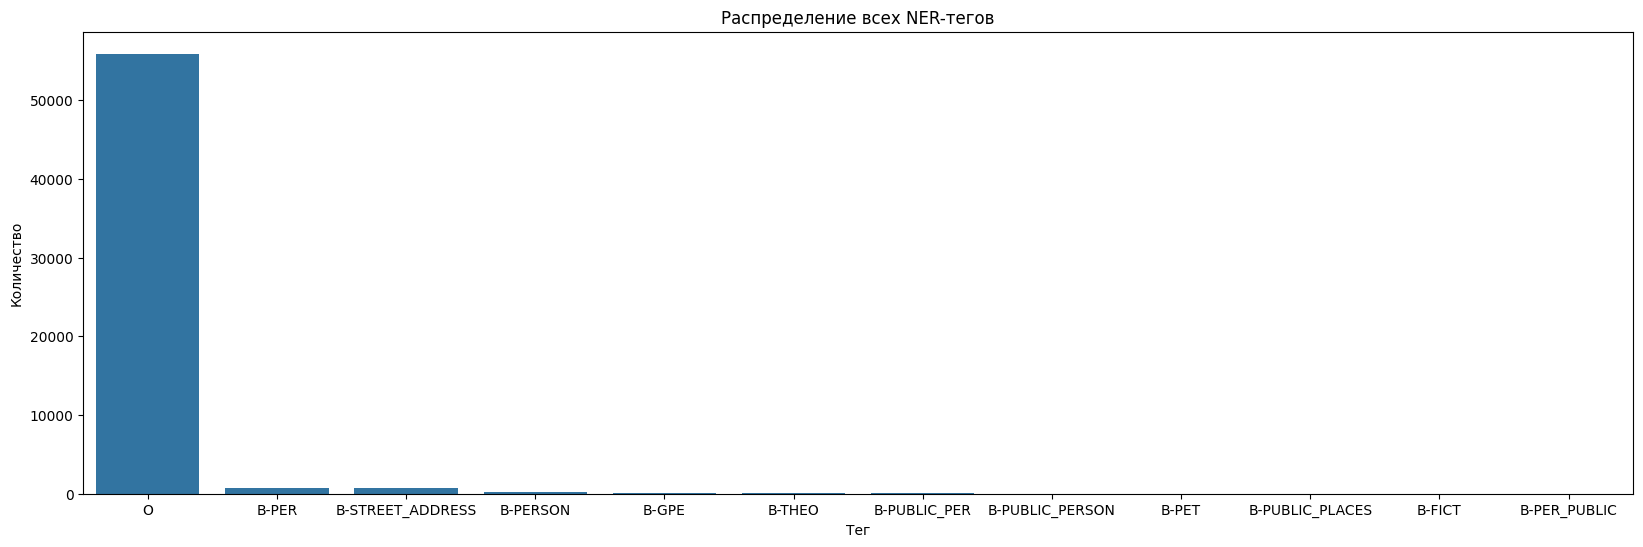

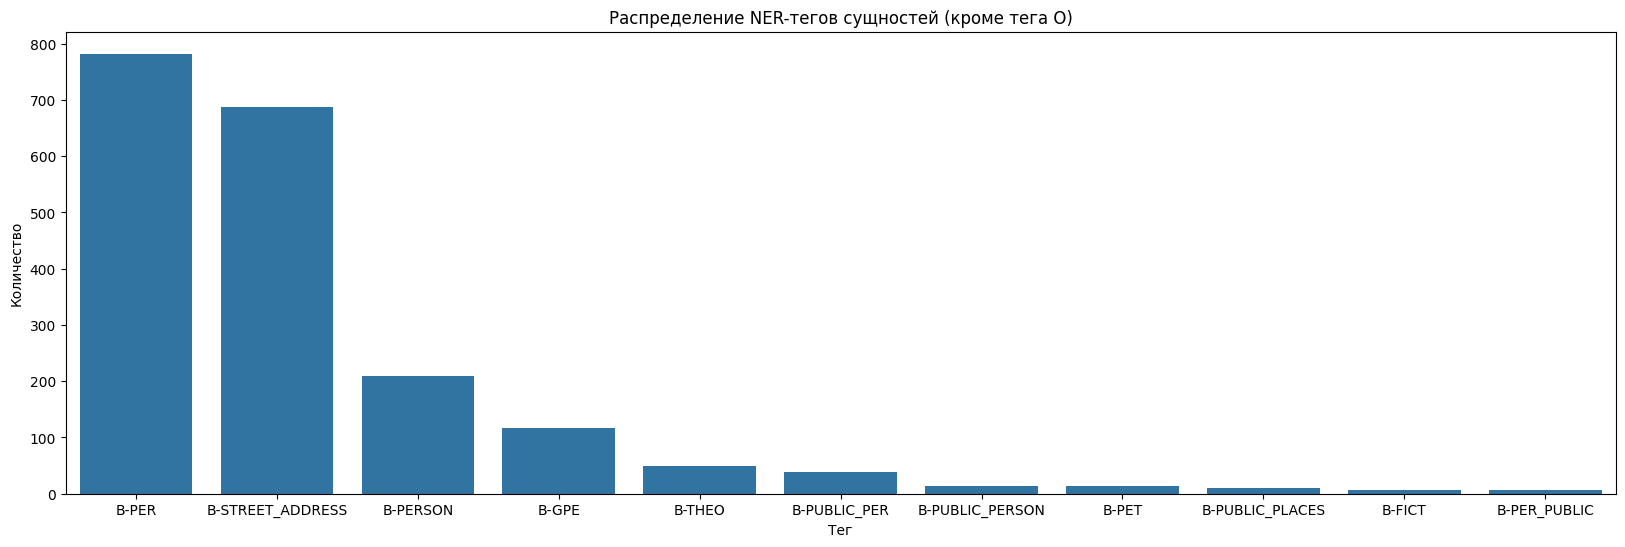

In [200]:
tag_count = {tag : 0 for tag in ner_tags}

for tag in all_tags:
    tag_count[tag] += 1

tag_count = dict(sorted(tag_count.items(), key=lambda item: item[1], reverse=True))

meaning_tag_count = {items[0] : items[1] for items in tag_count.items() if items[0] != 'O'}

for tag, count in tag_count.items():
    print(f"{tag:<20} {count}")

plt.figure(figsize=(20, 6))
sns.barplot(x=list(tag_count.keys()), y=list(tag_count.values()))
plt.title('Распределение всех NER-тегов')
plt.xlabel('Тег')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(20, 6))
sns.barplot(x=list(meaning_tag_count.keys()), y=list(meaning_tag_count.values()))
plt.title('Распределение NER-тегов сущностей (кроме тега O)')
plt.xlabel('Тег')
plt.ylabel('Количество')
plt.show()

В датасете есть метки с похожими названиями (Например 'B-PER', 'B-PERSON', 'B-PER_PUBLIC', 'B-PUBLIC_PER', 'B-PUBLIC_PERSON' и 'B-STREET_ADDRESS', 'B-PUBLIC_PLACES'). Проверим, не совпадают ли они по смыслу.

In [201]:
def get_tags_examples(tags=ner_tags):
    tag_examples = {tag : [] for tag in tags}

    for tag in tags:
        for i in range(len(jayguard_dataset['train'])):
            line_tokens = jayguard_dataset['train']['tokens'][i]
            line_tags = jayguard_dataset['train']['ner_tags'][i]

            if tag in line_tags:
                tag_index = line_tags.index(tag)
                token_with_tag = line_tokens[tag_index]

                html_text = "Полный текст: "
                for j in range(len(line_tokens)):
                    if j == tag_index:
                        html_text += f"<span style='background-color:{'#A0C4FF'}; border-radius: 4px; padding: 2px; margin:1px'><b>{line_tokens[j]}</b> <sub style='font-size: 0.7em;'>{tag}</sub></span> "
                    else:
                        html_text += f"{line_tokens[j]} "

                tag_examples[tag].append({
                    'token': token_with_tag,
                    'full_text': html_text
                })

    return tag_examples

In [202]:
# @title Метки личностей
suspicious_tags_persons = ['B-PER', 'B-PERSON', 'B-PER_PUBLIC', 'B-PUBLIC_PER', 'B-PUBLIC_PERSON']
suspicious_tags_places = ['B-GPE', 'B-PUBLIC_PLACES', 'B-STREET_ADDRESS']
other_tags = ['B-FICT', 'B-PET', 'B-THEO', 'O']

num_examples = 3

print("Примеры для ""Подозрительных"" тегов:")
for tag, example in get_tags_examples(suspicious_tags_persons).items():
    print(f"\nТег: {tag}")
    for i in range(min(num_examples, len(example))):
        print(f"\nПример: {i + 1}")
        print(f"Токен: '{example[i]['token']}'")
        display(HTML(example[i]['full_text']))

Примеры для Подозрительных тегов:

Тег: B-PER

Пример: 1
Токен: 'асия'



Пример: 2
Токен: 'Петром'



Пример: 3
Токен: 'ВАСИЛИЙ'



Тег: B-PERSON

Пример: 1
Токен: 'Иванова'



Пример: 2
Токен: 'алексей'



Пример: 3
Токен: 'Ольга'



Тег: B-PER_PUBLIC

Пример: 1
Токен: 'Доном'



Пример: 2
Токен: 'Виктор'



Тег: B-PUBLIC_PER

Пример: 1
Токен: 'Викгтор'



Пример: 2
Токен: '*'



Пример: 3
Токен: '*'



Тег: B-PUBLIC_PERSON

Пример: 1
Токен: 'Вацлав'



Пример: 2
Токен: 'путина'



Пример: 3
Токен: 'Горбачеву'


In [203]:
# @title Метки адресов и локаций
for tag, example in get_tags_examples(suspicious_tags_places).items():
    print(f"\nТег: {tag}")
    for i in range(min(num_examples, len(example))):
        print(f"\nПример: {i + 1}")
        print(f"Токен: '{example[i]['token']}'")
        display(HTML(example[i]['full_text']))


Тег: B-GPE

Пример: 1
Токен: 'Москве'



Пример: 2
Токен: 'Подольске'



Пример: 3
Токен: 'подольске'



Тег: B-PUBLIC_PLACES

Пример: 1
Токен: 'ВВЦ'



Пример: 2
Токен: 'Центральной'



Пример: 3
Токен: 'Соборной'



Тег: B-STREET_ADDRESS

Пример: 1
Токен: 'Тверской'



Пример: 2
Токен: 'ул.'



Пример: 3
Токен: 'ул.'


In [204]:
# @title Подробнее рассмотрим метку GPE, так как сущности данного типа могут выступать как адреса или политические субъекты
for tag, example in get_tags_examples(['B-GPE']).items():
    print(f"\nТег: {tag}")
    for i in range(20):
        display(HTML(example[i]['full_text']))


Тег: B-GPE


Токены с меткой GPE содержат в основном именно адресную информацию, поэтому метку GPE можно отнести к  категории локаций

In [205]:
# @title Прочие метки
print("Примеры для остальных тегов:")
for tag, example in get_tags_examples(other_tags).items():
    print(f"\nТег: {tag}")
    for i in range(min(num_examples, len(example))):
        print(f"\nПример: {i + 1}")
        print(f"Токен: '{example[i]['token']}'")
        display(HTML(example[i]['full_text']))

Примеры для остальных тегов:

Тег: B-FICT

Пример: 1
Токен: 'Щелкунчика'



Пример: 2
Токен: 'снегурочки'



Пример: 3
Токен: 'Центральной'



Тег: B-PET

Пример: 1
Токен: 'Снежок'



Пример: 2
Токен: 'Корги'



Тег: B-THEO

Пример: 1
Токен: 'эффект'



Пример: 2
Токен: 'диаграммы'



Пример: 3
Токен: 'Теорема'



Тег: O

Пример: 1
Токен: 'Слушай,'



Пример: 2
Токен: 'Уважаемая'



Пример: 3
Токен: 'Пациентка'


 "Подозрительные" метки действительно имеют общий смысл. Сгруппируем их в два тега - Person и Location и приведем набор тегов к формату BIO.

In [206]:
tag_aggregation = {'B-PER': 'B-PER',
              'B-PERSON': 'B-PER',
              'B-PER_PUBLIC': 'B-PER',
              'B-PUBLIC_PER': 'B-PER',
              'B-PUBLIC_PERSON': 'B-PER',

              'B-STREET_ADDRESS': 'B-LOC',
              'B-PUBLIC_PLACES': 'B-LOC',
              'B-GPE': 'B-LOC',

              'B-FICT': 'B-FICT',
              'B-PET': 'B-PET',
              'B-THEO': 'B-THEO',

              'O': 'O'
             }

jayguard_df = train_pd = pd.DataFrame(jayguard_dataset['train'])

for i in range(len(jayguard_df['ner_tags'])):
    for j in range(len(jayguard_df['ner_tags'][i])):
        if jayguard_df['ner_tags'][i][j] in tag_aggregation.keys():
            jayguard_df['ner_tags'][i][j] = tag_aggregation[jayguard_df['ner_tags'][i][j]]
        else:
            jayguard_df['ner_tags'][i][j] = 'O'

In [207]:
all_tags = np.array([])
for i in range(len(jayguard_df['ner_tags'])):
    all_tags = np.concatenate((all_tags, jayguard_df['ner_tags'][i]))

ner_tags = np.unique(all_tags)

num_tags = len(ner_tags)
tag2id = {label: i for i, label in enumerate(ner_tags)}

print(f"Количество обновлённых классов: {num_tags}")
print(f"Обновлённые метки NER: {ner_tags}")

Количество обновлённых классов: 6
Обновлённые метки NER: ['B-FICT' 'B-LOC' 'B-PER' 'B-PET' 'B-THEO' 'O']


Рассмотрим распределение меток после группировки

O                    55911
B-PER                1050
B-LOC                814
B-THEO               50
B-PET                13
B-FICT               6


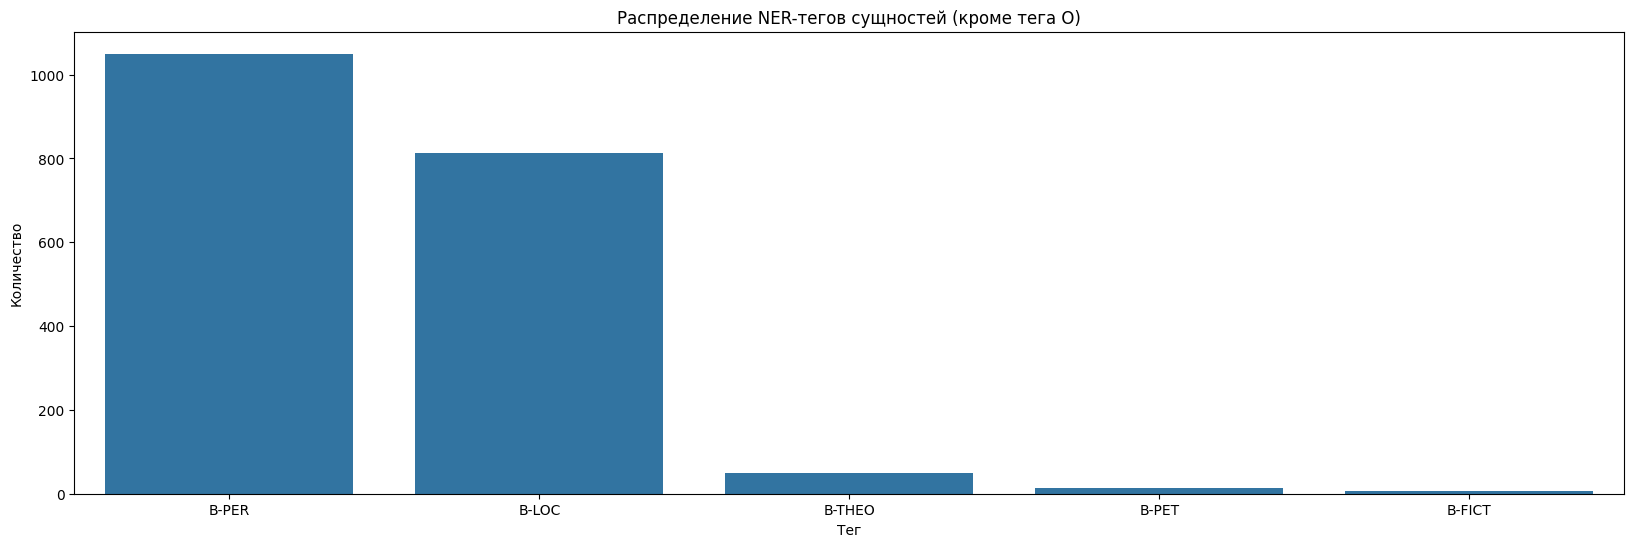

In [208]:
tag_count = {tag : 0 for tag in ner_tags}

for tag in all_tags:
    tag_count[tag] += 1

tag_count = dict(sorted(tag_count.items(), key=lambda item: item[1], reverse=True))

meaning_tag_count = {items[0] : items[1] for items in tag_count.items() if items[0] != 'O'}

for tag, count in tag_count.items():
    print(f"{tag:<20} {count}")

plt.figure(figsize=(20, 6))
sns.barplot(x=list(meaning_tag_count.keys()), y=list(meaning_tag_count.values()))
plt.title('Распределение NER-тегов сущностей (кроме тега O)')
plt.xlabel('Тег')
plt.ylabel('Количество')
plt.show()

Наблюдается значительный дисбаланс меток - метка THEO встречается редко, метки PET и FICT почти не предствлены. Возможно PET и FICT стоит исключить из датасета. При малом количестве данных они скорее будут ухудщать точность для других меток

Теперь для каждой метки посмотрим распределение длин сущностей (в токенах)

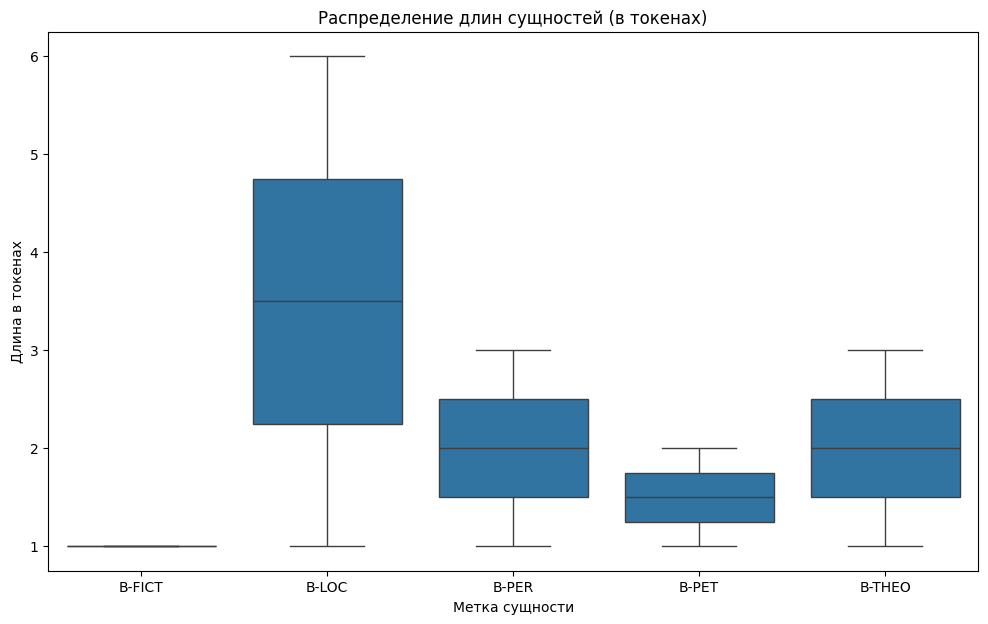

Средняя длина сущности по типам:
Tag
B-FICT    1.0
B-LOC     3.5
B-PER     2.0
B-PET     1.5
B-THEO    2.0
Name: Length, dtype: float64


In [209]:
entity_lengths = {tag : {} for tag in ner_tags}
for i in range(len(jayguard_df)):
    prev_tag = ""
    counter = 0
    for j in range(len(jayguard_df['ner_tags'][i])):
        current_tag = jayguard_df['ner_tags'][i][j]
        if current_tag != prev_tag:
            if prev_tag != "":
                if counter in entity_lengths[prev_tag].keys():
                    entity_lengths[prev_tag][counter] += 1
                else:
                    entity_lengths[prev_tag][counter] = 1

            prev_tag = current_tag
            counter = 0
        counter += 1

entity_lengths_list = []
for tag in ner_tags:
    for seq_length in entity_lengths[tag].keys():
        if tag != 'O':
            entity_lengths_list.append((tag, seq_length, entity_lengths[tag][seq_length]))

df_lengths = pd.DataFrame(entity_lengths_list, columns=['Tag', 'Length', 'Count'])

plt.figure(figsize=(12, 7))
sns.boxplot(x='Tag', y='Length', data=df_lengths, showfliers=False)
plt.title('Распределение длин сущностей (в токенах)')
plt.xlabel('Метка сущности')
plt.ylabel('Длина в токенах')
plt.show()

print("Средняя длина сущности по типам:")
print(df_lengths.groupby('Tag')['Length'].mean().round(2))

Из пяти значимых меток сущности четырех находятся в диапозоне до трех токенов. Наибольшие длина и разброс наблюдаются у сущностей локаций. В ценлом большинство сущностей в тексте состоит из нескольких токенов

Все метки кроме 'O' в датасете размечены как B-метки. Отметим те из них, которые идут после В- или I- меток того же типа как I-метки

In [210]:
def tags_to_bio(dataset):
    for i in range(len(dataset['ner_tags'])):
        tags = dataset['ner_tags'][i]
        bio_tags = []

        for j in range(len(tags)):
            if tags[j] == 'O':
                bio_tags.append(tags[j])
            else:
                entity_type = tags[j][2:]
                if j > 0 and tags[j - 1] != 'O':
                    prev_entity_type = tags[j - 1][2:]
                    if prev_entity_type == entity_type:
                        bio_tags.append(f'I-{entity_type}')
                    else:
                        bio_tags.append(tags[j])
                else:
                    bio_tags.append(tags[j])
        dataset['ner_tags'][i] = bio_tags

    return dataset

In [211]:
jayguard_df = tags_to_bio(jayguard_df)

Посмотрим на изменения в составе меток и распределении их количества

In [212]:
all_tags = np.array([])
for i in range(len(jayguard_df['ner_tags'])):
    all_tags = np.concatenate((all_tags, jayguard_df['ner_tags'][i]))

ner_tags = np.unique(all_tags)

num_tags = len(ner_tags)
tag2id = {label: i for i, label in enumerate(ner_tags)}

print(f"Количество обновлённых классов: {num_tags}")
print(f"Обновлённые метки NER: {ner_tags}")

Количество обновлённых классов: 10
Обновлённые метки NER: ['B-FICT' 'B-LOC' 'B-PER' 'B-PET' 'B-THEO' 'I-LOC' 'I-PER' 'I-PET'
 'I-THEO' 'O']


O                    55911
B-PER                806
I-LOC                423
B-LOC                391
I-PER                244
B-THEO               34
I-THEO               16
B-PET                12
B-FICT               6
I-PET                1


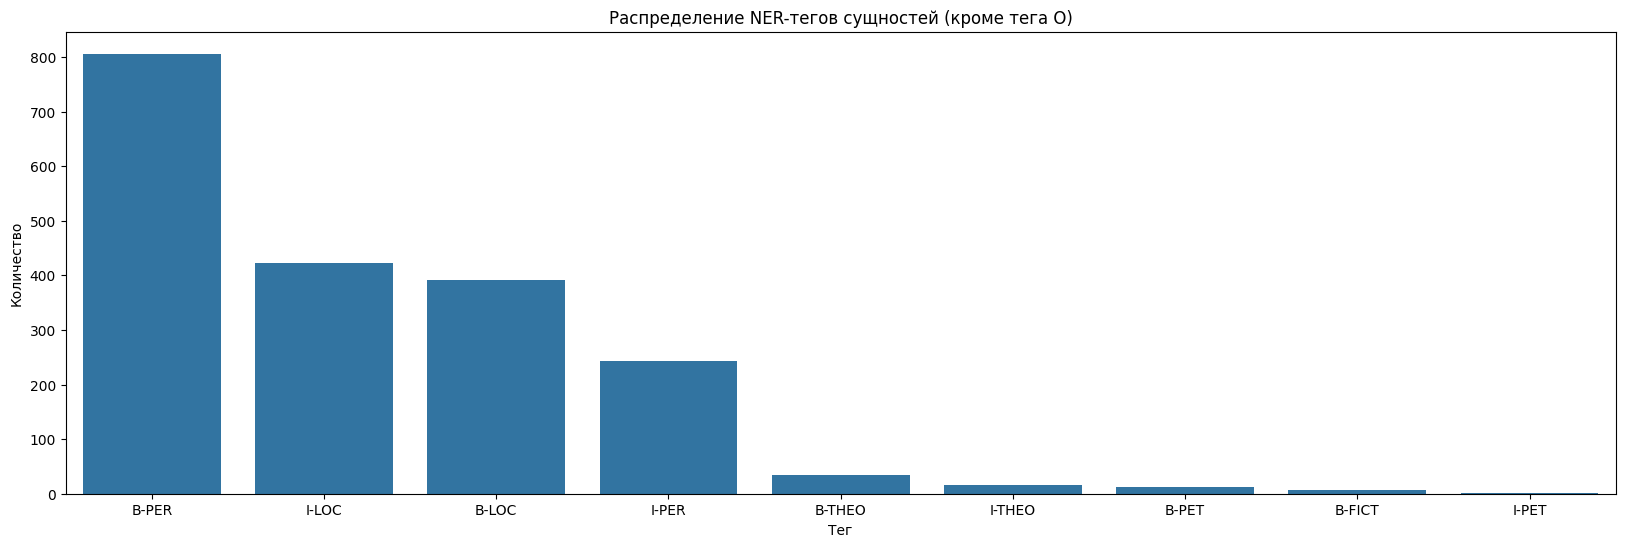

In [213]:
tag_count = {tag : 0 for tag in ner_tags}

for tag in all_tags:
    tag_count[tag] += 1

tag_count = dict(sorted(tag_count.items(), key=lambda item: item[1], reverse=True))

meaning_tag_count = {items[0] : items[1] for items in tag_count.items() if items[0] != 'O'}

for tag, count in tag_count.items():
    print(f"{tag:<20} {count}")

plt.figure(figsize=(20, 6))
sns.barplot(x=list(meaning_tag_count.keys()), y=list(meaning_tag_count.values()))
plt.title('Распределение NER-тегов сущностей (кроме тега O)')
plt.xlabel('Тег')
plt.ylabel('Количество')
plt.show()

Проведём поиск редких, лишних и "смешанных" токенов в данных - под "смешанных" токенами подразумеваются слова, соединенные со знаками препинания, под "лишними" - токены, состоящие исключительно из знаков препинания, а также отдельные незначимые токены (ранее в примерах можно было наблюдать предложения с первым токеном "LAST_APP_RESPONSE:" или "LAST_USER_REQUEST:")

In [214]:
def show_rare_tokens_info(word_counts):
    print(f"Общее количество уникальных токенов в данных: {len(word_counts)}")

    single_occurrence_words = sum(1 for count in word_counts.values() if count == 1)
    print(f"Количество токенов, которые встречаются только 1 раз: {single_occurrence_words} ({(single_occurrence_words / len(word_counts)) * 100:.2f}%)")

    print("\nСамые редкие токены:")
    print(word_counts.most_common()[-10:])

    print("\nТокены с лишей пунктуацией:")
    garbage_examples = []
    allowed_chars_re_check = re.compile(r"^[a-zа-яё-]")
    for word, count in word_counts.most_common():
        if not allowed_chars_re_check.match(word) and not word.isnumeric():
            garbage_examples.append(word)
        if len(garbage_examples) >= 10:
            break
    print(garbage_examples)

    print("\nЛишние англоязычные токены:")
    garbage_examples = []
    forbidden_chars_re_check = re.compile(r"last_app_response|last_user_request|last app response|last user request")
    for word, count in word_counts.most_common():
        if forbidden_chars_re_check.match(word):
            garbage_examples.append(word)
        if len(garbage_examples) >= 10:
            break
    print(garbage_examples)

    return word_counts

In [215]:
all_tokens = []
for i in range(len(jayguard_df['tokens'])):
    for j in range(len(jayguard_df['tokens'][i])):
        all_tokens.append(jayguard_df['tokens'][i][j].lower())

raw_word_counts = Counter(all_tokens)

count_outer = show_rare_tokens_info(raw_word_counts)

Общее количество уникальных токенов в данных: 18151
Количество токенов, которые встречаются только 1 раз: 11276 (62.12%)

Самые редкие токены:
[('перефразировать', 1), ('"картографирование', 1), ('ввода-вывода".', 1), ('наиля".', 1), ('явлений.', 1), ('отделом', 1), ('страховке', 1), ('чернышева', 1), ('мелентий', 1), ('маханенко', 1)]

Токены с лишей пунктуацией:
['*', '=', '|', '1.', '"клиент:', '2.', '.', '###', '3.', '—']

Лишние англоязычные токены:
['last_app_response:', 'last_user_request:', 'last_app_response.', 'last_app_response', 'last_app_response"', 'last_app_response".']


В датасете присутствуют токены, включающие в себя знаки препинания и символы " ' / < > { } [ ] проведём очистку этих токенов от лишних символов.
Отдельно обратим внимание на токены вида "Д.[номер]", "ул.[название]". Они несут адресную информацию

In [216]:
street_re = re.compile(r"ул[.]")

tags = np.array([])
for i in range(len(jayguard_df['tokens'])):
    tag_index = []
    line_tokens = jayguard_df['tokens'][i]
    for j in range(len(line_tokens)):
        lower_token = line_tokens[j].lower()
        if street_re.match(lower_token):
          tags = np.concatenate((tags, [jayguard_df['ner_tags'][i][j]]))
          tag_index.append(j)

print(f"Метки токена 'ул.*'{np.unique(tags)}")

house_re = re.compile(r"д[.]")

tags = np.array([])
for i in range(len(jayguard_df['tokens'])):
    tag_index = []
    line_tokens = jayguard_df['tokens'][i]
    for j in range(len(line_tokens)):
        lower_token = line_tokens[j].lower()
        if house_re.match(lower_token):
          tags = np.concatenate((tags, [jayguard_df['ner_tags'][i][j]]))
          tag_index.append(j)

print(f"Метки токена 'д.*'{np.unique(tags)}")

Метки токена 'ул.*'['B-LOC' 'O']
Метки токена 'д.*'['B-LOC' 'I-LOC' 'O']


Рассмотрим строки, в которых токен д.* имеет метку 'O'

In [217]:
for i in range(len(jayguard_df['tokens'])):
    tag_index = []
    line_tokens = jayguard_df['tokens'][i]
    for j in range(len(line_tokens)):
        lower_token = line_tokens[j].lower()
        if house_re.match(lower_token) and jayguard_df['ner_tags'][i][j] == 'O':
          tag_index.append(j)
    if len(tag_index) > 0:
      print(f"\nСтрока датасета {i}")
      html_text = ""
      for j in range(len(line_tokens)):
          if j in tag_index:
              tag = jayguard_df['ner_tags'][i][j]
              html_text += f"<span style='background-color:{'#A0C4FF'}; border-radius: 4px; padding: 2px; margin:1px'><b>{line_tokens[j]}</b> <sub style='font-size: 0.7em;'>{tag}</sub></span> "
          else:
              html_text += f"{line_tokens[j]} "
      display(HTML(html_text))



Строка датасета 30



Строка датасета 31



Строка датасета 33



Строка датасета 64



Строка датасета 188



Строка датасета 193



Строка датасета 198



Строка датасета 215



Строка датасета 231



Строка датасета 232



Строка датасета 233



Строка датасета 236



Строка датасета 238



Строка датасета 251



Строка датасета 253



Строка датасета 262



Строка датасета 301



Строка датасета 315



Строка датасета 327



Строка датасета 329



Строка датасета 330



Строка датасета 349



Строка датасета 370



Строка датасета 382



Строка датасета 393



Строка датасета 394



Строка датасета 403



Строка датасета 415



Строка датасета 424



Строка датасета 425



Строка датасета 428



Строка датасета 431



Строка датасета 432



Строка датасета 583



Строка датасета 745



Строка датасета 756



Строка датасета 777


В данных значительное количество уникальных токенов - их нужно удалить, чтобы избежать переобучения модели
Проведём фильтрацию токенов:
1. Все токены с датой или временем заменим на отдельный токен `<DATETIME>`
2. Заменим знаки пунктуации кроме "-" в токенах с текстом. Токены "ул.*" и "д.*" с метками кроме 'O' оставим без изменения
3. Токены, состоящие полностью из знаков пунктуации кроме ".", ",", "?" и "!" удалим
3. Все числовые данные заменим на отдельный токен `<NUM>`
4. Удалим токены c меткой 'O', встречающиеся менее 3 раз

In [218]:
for i in range(len(jayguard_df['tokens'])):
    for j in range(len(jayguard_df['tokens'][i])):
        found_dates = list(datefinder.find_dates(jayguard_df['tokens'][i][j]))
        if len(found_dates) > 0:
          jayguard_df['tokens'][i][j] = '<DATETIME>'

In [219]:
added_punct_re = re.compile(r'[^\s\w-][\sa-zа-яё]|[\sa-zа-яё][^\s\w-]|_[\sa-zа-яё]|[\sa-zа-яё]_')

for i in range(len(jayguard_df['tokens'])):
    for j in range(len(jayguard_df['tokens'][i])):
        lower_token = jayguard_df['tokens'][i][j].lower()
        if added_punct_re.match(lower_token):
          if not (house_re.match(lower_token) and jayguard_df['ner_tags'][i][j] != 'O') and not street_re.match(lower_token) and lower_token != '<datetime>':
            replaced_token = re.sub(r'[^\s\w-]|_', ' ', jayguard_df['tokens'][i][j])
            replaced_token = re.sub(r'\s+', ' ', replaced_token)
            jayguard_df['tokens'][i][j] = replaced_token.strip()

for i in range(len(jayguard_df['tokens'])):
    for j in range(len(jayguard_df['tokens'][i])):
      if jayguard_df['tokens'][i][j] != '<DATETIME>':
        replaced_token = re.sub(r"[№«»@'*#+=\(\)\<\>\{\}\[\]\|$\/]", ' ', jayguard_df['tokens'][i][j])
        replaced_token = re.sub(r'["]', ' ', replaced_token)
        replaced_token = re.sub(r'\s+', ' ', replaced_token)
        jayguard_df['tokens'][i][j] = replaced_token.strip().replace("`", "")


In [220]:
num_re = re.compile(r'\d+')

for i in range(len(jayguard_df['tokens'])):
    for j in range(len(jayguard_df['tokens'][i])):
        lower_token = jayguard_df['tokens'][i][j].lower()
        if num_re.match(lower_token):
          jayguard_df['tokens'][i][j] = '<NUM>'

In [221]:
all_tokens = []
for i in range(len(jayguard_df['tokens'])):
    for j in range(len(jayguard_df['tokens'][i])):
        all_tokens.append(jayguard_df['tokens'][i][j].lower())

raw_word_counts = Counter(all_tokens)

count_outer = show_rare_tokens_info(raw_word_counts)

Общее количество уникальных токенов в данных: 16576
Количество токенов, которые встречаются только 1 раз: 10042 (60.58%)

Самые редкие токены:
[('онисимом', 1), ('лагиным,', 1), ('ввода-вывода .', 1), ('наиля .', 1), ('явлений.', 1), ('отделом', 1), ('страховке', 1), ('чернышева', 1), ('мелентий', 1), ('маханенко', 1)]

Токены с лишей пунктуацией:
['<num>', '', '<datetime>', '.', '—', '–', '•', '\\', '👉', ',']

Лишние англоязычные токены:
['last_app_response:', 'last_user_request:', 'last app response', 'last_app_response', 'last_app_response.', 'last app response перефразировка', 'last_app_response .']


In [222]:
pure_punct_re = re.compile(r'[^\s\w.,!?-]')

word_counts = Counter()
for i in range(len(jayguard_df['tokens'])):
    for j in range(len(jayguard_df['tokens'][i])):
        word = jayguard_df['tokens'][i][j].lower()
        word_counts[word] += 1

print(f"Количество уникальных токенов до фильтрации: {len(word_counts)}")

MIN_FREQ = 3
word2id = {'<UNK>': 0, '<NUM>': 1, '<DATETIME>' : 2}
current_id = 3

for word, count in word_counts.items():
    if count >= MIN_FREQ and not pure_punct_re.match(word.lower()) and not word == "":
        word2id[word] = current_id
        current_id += 1

id2word = {i: word for word, i in word2id.items()}
vocab_size = len(word2id)

print(f"Количество слов с частотой >= {MIN_FREQ}: {vocab_size}")

Количество уникальных токенов до фильтрации: 16576
Количество слов с частотой >= 3: 3606


In [223]:
for i in range(len(jayguard_df['tokens'])):
    for j in range(len(jayguard_df['tokens'][i])):
        lower_token = jayguard_df['tokens'][i][j].lower()
        if pure_punct_re.match(lower_token) and lower_token != '<datetime>' and lower_token != '<num>':
          continue
          print(lower_token)

In [224]:
for i in range(len(jayguard_df['tokens'])):
    new_tokens = []
    new_tags = []

    for j in range(len(jayguard_df['tokens'][i])):
        if word2id.get(jayguard_df['tokens'][i][j], word2id['<UNK>']) != word2id['<UNK>'] or jayguard_df['ner_tags'][i][j] != 'O':
            new_tokens.append(jayguard_df['tokens'][i][j])
            new_tags.append(jayguard_df['ner_tags'][i][j])

    jayguard_df['tokens'][i] = new_tokens
    jayguard_df['ner_tags'][i] = new_tags

word_counts_outer = Counter()
for i in range(len(jayguard_df['tokens'])):
    for j in range(len(jayguard_df['tokens'][i])):
        word = jayguard_df['tokens'][i][j].lower()
        word_counts_outer[word] += 1

print(f"Количество уникальных токенов после фильтрации: {len(word_counts_outer)}")

Количество уникальных токенов после фильтрации: 4336


Разобьём датасет на выборки

In [225]:
tokens_list = jayguard_df['tokens'].tolist()
ner_tags_list = jayguard_df['ner_tags'].tolist()

train_tokens, test_tokens, train_tags, test_tags = train_test_split(
    tokens_list,
    ner_tags_list,
    test_size=0.2,
    random_state=SEED
)

splits = {
    'train': {
        'tokens': train_tokens,
        'ner_tags': train_tags
    },
    'test': {
        'tokens': test_tokens,
        'ner_tags': test_tags
    }
}

Обучим и протестируем модель SpaCy-ru на наших данных

Составим словарь сущностей и файл конфигурации для модели

In [226]:
def evaluate(ner_model, examples):
    results = []
    scorer = Scorer()
    for vocab_unit in examples:
        doc_gold_text = ner_model.make_doc(vocab_unit['text'])
        result = Example.from_dict(doc_gold_text, {"entities": vocab_unit['entities']})
        result.predicted = ner_model(result.predicted)
        results.append(result)

    return scorer.score(results)

In [227]:
def get_train_test_vocabs(train_data, test_data, no_bio_map):
  training_vocab = []
  for i in range(len(train_data['tokens'])):
    entities = []
    current_char_idx = 0
    prev_char_idx = 0
    for j in range(len(train_data['tokens'][i])):
      current_char_idx = prev_char_idx + len(train_data['tokens'][i][j])
      if train_data['ner_tags'][i][j] != 'O':
        if no_bio_map:
          entities.append((prev_char_idx, current_char_idx, train_data['ner_tags'][i][j][2:]))
        else:
          entities.append((prev_char_idx, current_char_idx, train_data['ner_tags'][i][j]))
      prev_char_idx = current_char_idx + 1

    training_vocab.append({"text" : " ".join(train_data['tokens'][i]),
                          "entities" : entities})

  test_vocab = []
  for i in range(len(test_data['tokens'])):
    entities = []
    current_char_idx = 0
    prev_char_idx = 0
    for j in range(len(test_data['tokens'][i])):
      current_char_idx = prev_char_idx + len(test_data['tokens'][i][j])
      if test_data['ner_tags'][i][j] != 'O':
        if no_bio_map:
          entities.append((prev_char_idx, current_char_idx, test_data['ner_tags'][i][j][2:]))
        else:
          entities.append((prev_char_idx, current_char_idx, test_data['ner_tags'][i][j]))
      prev_char_idx = current_char_idx + 1

    test_vocab.append({"text" : " ".join(test_data['tokens'][i]),
                          "entities" : entities})

  return training_vocab, test_vocab

In [228]:
def prepare_training_data(nlp_model, training_vocab):
  db = DocBin()
  for vocab_unit in training_vocab:
      doc = nlp_model.make_doc(vocab_unit['text'])
      ents = []
      for start, end, label in vocab_unit["entities"]:
          span = doc.char_span(start, end, label=label, alignment_mode="contract")
          if span is None:
              continue
          else:
              ents.append(span)
      doc.ents = ents
      db.add(doc)

  db.to_disk("./training_data.spacy")

In [229]:
def train_test_ner(train_data, test_data, nlp_model, no_bio_map=False):
  training_vocab, test_vocab = get_train_test_vocabs(train_data, test_data, no_bio_map)
  prepare_training_data(nlp_model, training_vocab)

  if not os.path.exists('config.cfg'):
    !python -m spacy init config config.cfg --lang ru --pipeline ner --optimize efficiency
  !python -m spacy train config.cfg --output ./ --paths.train ./training_data.spacy --paths.dev ./training_data.spacy

  nlp_ner = spacy.load("/content/model-best")
  results = evaluate(nlp_ner, test_vocab)

  print(f"Общие результаты: precision {round(results['ents_p'], 2)}, recall {round(results['ents_r'], 2)}, f1-score {round(results['ents_f'], 2)}")
  for tag, metrics in results['ents_per_type'].items():
    for metric_name in metrics.keys():
      metrics[metric_name] = round(metrics[metric_name], 2)
    print(tag, metrics)
  return results

Запуски выполняются для тегов с разделением на B- и I- и без, дополнительные настройки:
 * batch_size = 256
 * max_steps = 2000
 * eval_frequency = 500

In [230]:
model = spacy.blank('ru')
blanknobio = train_test_ner(splits['train'], splits['test'], model, True)

ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    105.73    0.12    0.08    0.20    0.00
  1     500        477.51   2941.57   84.05   90.13   78.74    0.84
  3    1000        634.35   1112.48   94.28   94.43   94.12    0.94
  7    1500        929.51    842.50   97.82   97.99   97.66    0.98
 15    2000       1208.71    656.69   99.33   99.80   98.86    0.99
✔ Saved pipeline to output directory
model-last
Общие результаты: precision 0.79, recall 0.61, f1-score 0.69
PER {'p': 0.83, 'r': 0.74, 'f': 0.78}
LOC {'p': 0.74, 'r': 0.55, 'f': 0.63}
THEO {'p': 1.0, 'r': 0.17, 'f': 0.29}
PET {'p': 0.0, 'r

In [231]:
model = spacy.blank('ru')
blankbio = train_test_ner(splits['train'], splits['test'], model, False)

ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    109.35    0.00    0.00    0.00    0.00
  1     500        281.35   3014.17   82.95   87.47   78.88    0.83
  3    1000        665.01   1263.42   94.56   95.56   93.58    0.95
  7    1500       1335.05    976.02   97.87   99.04   96.72    0.98
 15    2000       1102.78    677.99   99.26   99.80   98.73    0.99
✔ Saved pipeline to output directory
model-last
Общие результаты: precision 0.81, recall 0.63, f1-score 0.71
B-PER {'p': 0.83, 'r': 0.78, 'f': 0.81}
B-LOC {'p': 0.82, 'r': 0.56, 'f': 0.66}
I-LOC {'p': 0.81, 'r': 0.56, 'f': 0.67}
I-PER {'p':

* Лучше всего модель определяет классы PER - у него лучший среди всех меток баланс полноты (Предположительно более низкая точность у B-PER связана с ошибочной классификацией PET и FICT как PER) и точности, однако между B-PER и I-PER наблюдается значительный разрыв, предположительно вызванный дисбалансом этих классов (разница в количстве в 3+ раза)
* Для классов группы LOC точность предсказаний несколько ниже, однако между B- и I- метками разрыв меньше, чем у PER
* Результаты для THEO хуже в следствии малого количества данных для обучения и тестов, в случаях с PET и FICT качественную классификацию нельзя провести без использования синтетических данных для обучения, так как они присутствуют всего в 2-х и 6-и строках датасета сответственно

In [232]:
checked_tags = ['B-PET', 'I-PET', 'B-FICT', 'I-FICT']
tag_rows = {tag : [] for tag in checked_tags}

for tag in checked_tags:
  for i in range(len(jayguard_df)):
      line_tags = jayguard_df['ner_tags'][i]

      if tag in line_tags:
        tag_rows[tag].append(i)
tag_rows

{'B-PET': [506, 652],
 'I-PET': [506],
 'B-FICT': [55, 56, 80, 400, 401, 402],
 'I-FICT': []}